# Modelos para datos estructurados

> Creando modelos para datos estructurados usando FastAI.

- toc: true 
- badges: true
- comments: true
- categories: [practica]
- image: images/chart-preview.png


En este notebook se muestra cómo crear un modelo de clasificación para un dataset estructurado que contiene características categóricas usando una red neuronal. Para ello usaremos la librería [FastAI](https://www.fast.ai/).

Aunque para esta práctica no es necesario el uso de GPU, las pruebas serán más rápidas si tienes esta opción activada. 

## Librerías

Comenzamos actualizando la librería FastAI. Al finalizar la instalación deberás reiniciar el kernel (menú Entorno de ejecución -> Reiniciar Entorno de ejecución).

In [1]:
!pip install fastai -Uq

     |████████████████████████████████| 188 kB 10.1 MB/s 
     |████████████████████████████████| 56 kB 2.6 MB/s 


Cargamos a continuación las librerías que necesitaremos en esta práctica que son la parte de datos estructurados de la librería fastAI y la librería pandas. 

In [2]:
from fastai.tabular.all import *
import pandas as pd
import random

## Dataset

Para este ejemplo vamos a usar el [Adult Data Set](https://archive.ics.uci.edu/ml/datasets/Adult). Con este dataset se pretende ser capaz de predecir si una persona cobra más de 50000 dolares al año a partir de las siguientes características:

In [3]:
columns = ['age','workclass','fnlwgt','education',     
          'education-num','marital-status',
          'occupation', 'relationship', 'race',
          'sex','capital-gain','capital-loss',
          'hours-per-week','native-country','income']

Vamos a descargar el dataset usando los siguientes comandos. Debemos descargar tanto el conjunto de entrenamiento como el de test. 

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -O train.csv
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test -O test.csv

--2022-04-07 10:01:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘train.csv’

train.csv           100%[===================>]   3.79M  3.23MB/s    in 1.2s    

2022-04-07 10:01:50 (3.23 MB/s) - ‘train.csv’ saved [3974305/3974305]

--2022-04-07 10:01:50--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘test.csv’

test.csv            100%[===================>]   1.91M  1.85MB/s    in 1.0s    

2022-04-

Si inspeccionais el fichero de test veremos que la primera línea no proporciona información útil, y además los valores de la columna del salario incluyen un punto. Los siguientes comandos se encargan de eliminar la primera línea del fichero y de eliminar los puntos. 

In [5]:
# Eliminamos la primera línea del fichero de test
!sed '1d' test.csv > tmpfile; mv tmpfile test.csv

In [6]:
# Eliminamos los puntos del fichero de test
!sed 's/\.//' test.csv > tmpfile; mv tmpfile test.csv

## Carga de datos

Al igual que se trabajaba en la asignatura de aprendizaje automático pasamos a cargar ambos datasets. 

In [7]:
df_train = pd.read_csv('train.csv',header=None,names=columns)
df_test = pd.read_csv('test.csv',header=None,names=columns)

Para crear un modelo con datos estructurados en FastAI debemos:
- Indicar la columna que queremos predecir, es decir la variable dependiente.
- Las transformaciones que queremos aplicar a nuestro dataset. 
- Las características que son categóricas y continuas.

Nuestra variable dependiente va a ser el salario:

In [8]:
dep_var = 'income'

Las transformaciones que vamos a aplicar nuestro dataset son:
- Categorizar las variables categoricas de manera que se use un embedding.
- Reemplazar aquellos valores que faltan en el dataset por la media del resto de valores de ese descriptor.
- Normalizar los datos. 

Esto se consigue definiendo la siguiente lista de transformaciones. 

In [9]:
procs = [Categorify, FillMissing,Normalize]

Por último debemos indicar qué variables son continuas (números) o categóricas. De esto se encarga automáticamente la función `cont_cat_split`.

In [10]:
cont,cat = cont_cat_split(df_train, 1, dep_var=dep_var)

Podemos ver a hora que realmente las variables continuas y categóricas han sido separadas de forma correcta. 

In [11]:
cat

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [12]:
cont

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

## Entrenando un modelo

El proceso para entrenar un modelo es el mismo que hemos visto para los modelos de clasificación de imágenes y podemos usar toda la funcionalidad vista hasta ahora. Comenzamos definiendo un dataloader usando el método estático `from_df` de la clase `TabularDataLoaders`. Como siempre debemos definir un conjunto de validación, para ello debemos indicar los índices del dataset que tomaremos como conjunto de validación. En este caso vamos a tomar un 20% de los índices de manera aleatoria. 

In [13]:
dlsTrain = TabularDataLoaders.from_df(df_train,'.',procs=procs,
                                cat_names=cat,cont_names=cont,y_names='income',
                                valid_idx=random.sample(range(0,len(df_train)),int(len(df_train)*0.2)),bs=64)

Ahora definimos nuestro learner que va a ser una red neuronal, a la cual le tenemos que indicar el número de capas y neuronas con las que queremos trabajar. En este caso usaremos una red neuronal con dos capas ocultas la primera con 500 neuronas y la segunda con 250. 

In [14]:
learn = tabular_learner(dlsTrain, layers=[500,250],metrics=[accuracy])

Podemos ver la estructura del modelo que acabamos de construir.

In [15]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
    (7): Embedding(43, 13)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=58, out_features=500, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=500, out_features=250, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=250, out_features=2, bias=True)
    )
  )
)

Podemos ver que tenemos un `TabularModel` con una serie de embeddings. La siguiente celda nos sirve para ver qué es lo que hace un `TabularModel`. 

In [16]:
??TabularModel

Como hemos dicho tenemos toda la batería de funciones que ya conocemos, así que vamos a buscar el learning rate más adecuado.

SuggestedLRs(valley=0.0006918309954926372)

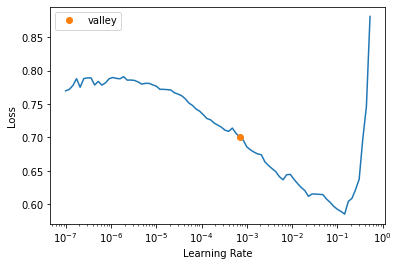

In [17]:
learn.lr_find()

Pasamos ahora a entrenar nuestro modelo.

In [18]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.350504,0.331476,0.843827,00:05
1,0.322696,0.321616,0.847205,00:05
2,0.330329,0.316916,0.848894,00:05
3,0.317356,0.321670,0.846898,00:05
4,0.322257,0.316217,0.851198,00:05
5,0.322551,0.320621,0.848587,00:05
6,0.318757,0.318485,0.851812,00:05
7,0.325365,0.320952,0.849048,00:05
8,0.305683,0.318356,0.852273,00:05
9,0.308657,0.320151,0.850276,00:05


## Evaluación

Hemos logrado una accuracy del 84.50 en el conjunto de validación, pero nos interesa ver el rendimiento de nuestro modelo en el conjunto de test. Para ello debemos primero combinar el conjunto de train y el conjunto de test para crear un dataloader en el que el conjunto de validación esté formado por todos los elementos del conjunto de test.

In [19]:
dfAll = pd.concat([df_train,df_test])
dlsTest = TabularDataLoaders.from_df(dfAll,'.',procs=procs,
                                cat_names=cat,cont_names=cont,y_names='income',
                                valid_idx=list(range(len(df_train)+1,len(dfAll))),bs=64)

Cambiamos ahora el dataloader del learner.

In [20]:
learn.dls=dlsTest

Y procedemos a obtener la accuracy de nuestro modelo en el conjunto de test. 

In [21]:
learn.validate()

(#2) [0.3215624988079071,0.8495700359344482]

También podemos usar nuestro modelo para hacer predicciones concretas con un ejemplo usando la función `predict` esto nos devolverá tres elementos: los datos sobre los que se ha realizado la predicción, la clase, y las probabilidades. 

In [22]:
learn.predict(df_test.iloc[0][:-1])

(   workclass  education  marital-status  occupation  relationship  race  sex  \
 0        5.0        2.0             5.0         8.0           4.0   3.0  2.0   
 
    native-country       age    fnlwgt  education-num  capital-gain  \
 0            40.0 -0.995675  0.350768      -1.197414     -0.145918   
 
    capital-loss  hours-per-week  income  
 0     -0.216656       -0.035429     0.0  ,
 tensor(0),
 tensor([0.9983, 0.0017]))